In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR
using Nevanlinna

In [2]:
T = BigFloat

BigFloat

In [3]:
beta::Float64 = 100
wmax::Float64 = 10
basis = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 

FiniteTempBasisSet with β = 100.0, ωmax = 10.0

In [4]:
include("../flex_src/IRFLEX.jl")

Main.IRFLEX

In [5]:
nsize::Int64 = 128
t_pra::Float64 = 0.0
filling::Float64 = 1.0
U = 0.5
hami = (x,y) -> IRFLEX.single_Hami(x,y,t_pra)
lat = IRFLEX.SingleLatticeModel(nsize, filling, U, SparseIR.β(basis), hami)
;

In [6]:
ratio_U = 0.0
precision = 1e-4
loose_precision = 1e+3*precision
gkf0 = IRFLEX.make_free_giw(lat, basis)
;

In [7]:
# Compute chi0
chi0kf = IRFLEX.calc_chi0(gkf0, lat, basis)

# Compute chi
chiskf = chi0kf ./ (1.0 .- lat.U*chi0kf)
;

In [8]:
hnw = (length(basis.smpl_wn_b.sampling_points)-1)÷2

36

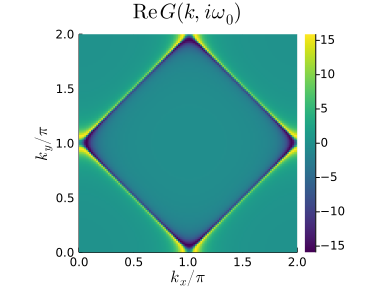

In [9]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(gkf0[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Re}\\,G(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

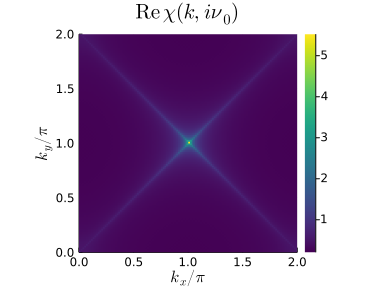

In [10]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(chiskf[hnw+1,:,:]),
    title=latexstring("\\mathrm{Re}\\,\\chi(k,i\\nu_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"),
    c=:viridis,
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [11]:
#smpl_wn_b = SparseIR.default_matsubara_sampling_points(basis.basis_b)
#smpl_wn_b = smpl_wn_b[smpl_wn_b .!= BosonicFreq(0)]
#smpl_wn_b_wo_zero = MatsubaraSampling(basis.basis_b, smpl_wn_b)
;

In [12]:
chisf = chi0kf[:,nsize÷2+1, nsize÷2+1]
#deleteat!(chisf, hnw+1)
#chisl = fit(smpl_wn_b_wo_zero, chisf, dim=1)
#chisf[37] = 0
chisl = fit(basis.smpl_wn_b, chisf, dim=1)
;

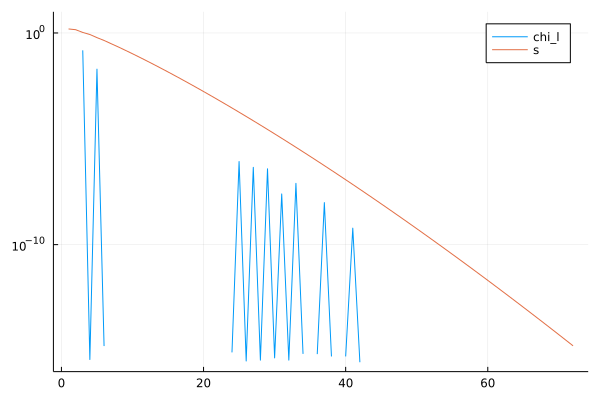

In [13]:
plot(yaxis=:log,ylims=(1e-16,10))
#plot()
plot!(real.(chisl),label="chi_l")
plot!(real.(basis.basis_b.s),label="s")

In [14]:
#smpl_wn_b_dense = MatsubaraSampling(basis.basis_b, SparseIR.BosonicFreq.(collect(-2332:2:2332)))
#chisl_d = fit(basis.smpl_wn_b, chisf)
#chisf_d = evaluate(smpl_wn_b_dense, chisl_d)
#deleteat!(chisf_d, 1167)
#chisf_d[1167]=0.0
#chisl_d = fit(smpl_wn_b_dense, chisf_d)
;

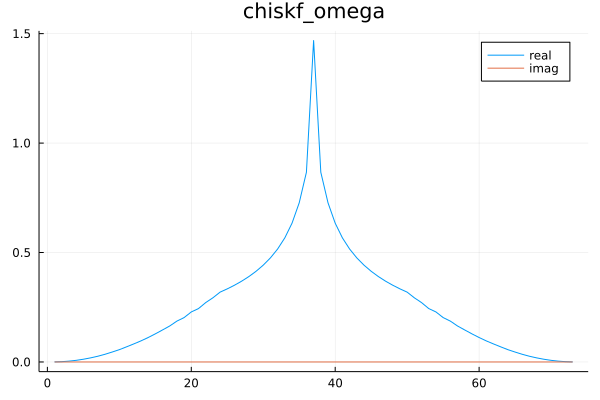

In [15]:
plot(title="chiskf_omega")
plot!(real.(chisf), label="real")
plot!(imag.(chisf), label="imag")

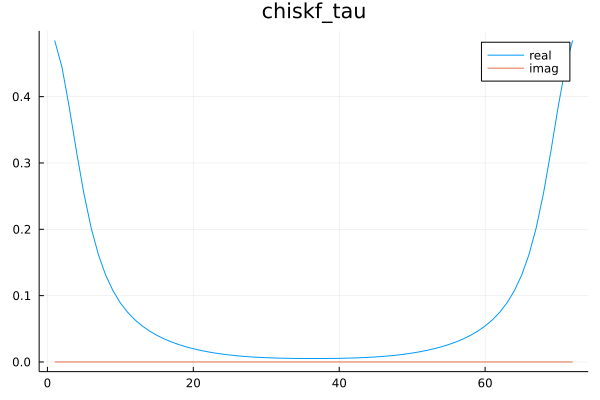

In [16]:
chist = evaluate(basis.smpl_tau_b, chisl)
plot(title="chiskf_tau")
plot!(real.(chist[:]), label="real")
plot!(imag.(chist[:]), label="imag")

In [17]:
chisw = evaluate(basis.smpl_wn_f, chisl)
;

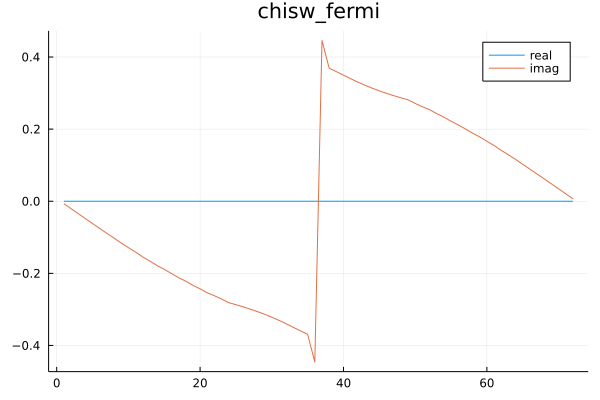

In [18]:
plot(title="chisw_fermi")
plot!(real.(chisw[:]), label="real")
plot!(imag.(chisw[:]), label="imag")

In [19]:
sum = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl))

0.9896561093259562

In [20]:
setprecision(512)

512

In [21]:
input_chi  = Array{Complex{T}}(undef, hnw) 
input_smpl = Array{Complex{T}}(undef, hnw) 
;

In [22]:
for i in 1:hnw
    input_smpl[i] = SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(basis))
    input_chi[i]  = -chisw[hnw+i]
end

In [49]:
N_real    =  1000
omega_max =  10.0
eta       =  0.01
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, input_smpl, input_chi)
#N_imag = hnw 
println("N_imag $(N_imag)")

N_imag is setted as 35
N_imag 35


In [50]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta, sum, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     1.445257e+00     6.393259e-01
 * time: 0.00041294097900390625
     1     1.262188e+00     1.749002e-01
 * time: 0.363677978515625
     2     1.187912e+00     8.010459e-02
 * time: 0.8046839237213135
     3     1.173393e+00     5.289366e-03
 * time: 1.0353081226348877
     4     1.173353e+00     1.498273e-03
 * time: 1.2859549522399902
     5     1.173351e+00     4.175151e-04
 * time: 1.7040209770202637
     6     1.173351e+00     4.715753e-05
 * time: 1.9355261325836182
     7     1.173351e+00     1.400732e-05
 * time: 2.16035795211792
     8     1.173351e+00     4.116710e-06
 * time: 2.50940203666687
     9     1.173351e+00     1.033089e-06
 * time: 2.75667405128479
    10     1.173351e+00     1.965034e-07
 * time: 3.131507158279419
    11     1.173351e+00     3.520551e-08
 * time: 3.4672670364379883
    12     1.173351e+00     8.163632e-09
 * time: 3.8449180126190186
max_theta=0.52645189858

In [51]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     1.173351e+00     8.163632e-09
 * time: 0.0003008842468261719
max_theta=0.526451898587336513248894784203701593205781466303066343750009589320316472395985477611111241740689468042648177768926612370665305514825810195566405906973579515
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     1.173351e+00     3.996123e-01
 * time: 0.0003528594970703125
     1     1.095990e+00     2.960794e-01
 * time: 0.29799795150756836
     2     1.005262e+00     1.155096e-01
 * time: 0.6903078556060791
     3     9.923601e-01     4.925233e-02
 * time: 1.5471110343933105
     4     9.886691e-01     2.367067e-02
 * time: 2.0208959579467773
     5     9.871564e-01     2.370084e-02
 * time: 2.468653917312622
     6     9.866754e-01     1.399513e-02
 * time: 2.8763320446014404
     7     9.864205e-01     4.477671e-03
 * time: 3.1330440044403076
     8     9.863961e-01     3.098361e-03
 * time: 3.4056758880615234
     9     9.

    13     5.781552e-01     3.992750e-03
 * time: 5.208441972732544
    14     5.781404e-01     4.229572e-03
 * time: 5.612109899520874
    15     5.781296e-01     2.932250e-03
 * time: 5.938985109329224
    16     5.781222e-01     2.315911e-03
 * time: 6.2566139698028564
    17     5.781171e-01     1.845836e-03
 * time: 6.695281982421875
    18     5.781128e-01     1.677731e-03
 * time: 7.069403886795044
    19     5.781094e-01     1.392332e-03
 * time: 7.360408067703247
    20     5.781068e-01     1.286050e-03
 * time: 7.6376988887786865
    21     5.781050e-01     9.113525e-04
 * time: 7.930999994277954
    22     5.781039e-01     7.783003e-04
 * time: 8.274687051773071
    23     5.781033e-01     5.391512e-04
 * time: 8.635838985443115
    24     5.781029e-01     4.745342e-04
 * time: 9.01064395904541
    25     5.781026e-01     3.843903e-04
 * time: 9.303927898406982
    26     5.781024e-01     3.656448e-04
 * time: 9.582242965698242
    27     5.781023e-01     3.229617e-04
 * tim

    38     4.210144e-01     8.914474e-05
 * time: 13.087538003921509
    39     4.210144e-01     8.266991e-05
 * time: 13.515773057937622
    40     4.210144e-01     6.536005e-05
 * time: 13.80509090423584
    41     4.210144e-01     5.966173e-05
 * time: 14.095545053482056
    42     4.210144e-01     4.713420e-05
 * time: 14.412231922149658
    43     4.210144e-01     4.399896e-05
 * time: 14.832802057266235
    44     4.210144e-01     3.458065e-05
 * time: 15.155961990356445
    45     4.210144e-01     3.379770e-05
 * time: 15.468394041061401
    46     4.210144e-01     2.819620e-05
 * time: 15.793783903121948
    47     4.210144e-01     2.633859e-05
 * time: 16.153021097183228
    48     4.210144e-01     2.441459e-05
 * time: 16.4510600566864
    49     4.210144e-01     2.203712e-05
 * time: 16.755781888961792
    50     4.210144e-01     2.048461e-05
 * time: 17.056967973709106
    51     4.210144e-01     1.778317e-05
 * time: 17.374629020690918
    52     4.210144e-01     1.630370e

    43     3.048363e-01     4.770946e-05
 * time: 17.674432039260864
    44     3.048363e-01     3.164552e-05
 * time: 17.990352869033813
    45     3.048363e-01     3.283768e-05
 * time: 18.502275943756104
    46     3.048363e-01     2.374778e-05
 * time: 18.827226877212524
    47     3.048363e-01     2.729124e-05
 * time: 19.352298974990845
    48     3.048363e-01     1.616529e-05
 * time: 19.706187963485718
    49     3.048363e-01     1.860173e-05
 * time: 20.477313995361328
    50     3.048363e-01     1.130792e-05
 * time: 20.817255973815918
    51     3.048363e-01     1.375193e-05
 * time: 21.367613077163696
    52     3.048363e-01     9.086477e-06
 * time: 21.718424081802368
    53     3.048363e-01     8.717983e-06
 * time: 22.154035091400146
    54     3.048363e-01     7.779799e-06
 * time: 22.5648410320282
    55     3.048363e-01     7.450267e-06
 * time: 22.904145002365112
    56     3.048363e-01     4.250496e-06
 * time: 23.22899603843689
    57     3.048363e-01     6.665484e

    45     1.936490e-01     2.126071e-04
 * time: 22.7375168800354
    46     1.936488e-01     1.703627e-04
 * time: 23.289062023162842
    47     1.936488e-01     1.023616e-04
 * time: 23.688518047332764
    48     1.936487e-01     8.403932e-05
 * time: 24.25973606109619
    49     1.936487e-01     6.968384e-05
 * time: 24.80584406852722
    50     1.936487e-01     7.147354e-05
 * time: 25.20666193962097
    51     1.936487e-01     4.220366e-05
 * time: 25.572751998901367
    52     1.936487e-01     4.029813e-05
 * time: 25.956212043762207
    53     1.936487e-01     4.213504e-05
 * time: 26.37494707107544
    54     1.936487e-01     3.357428e-05
 * time: 26.84340190887451
    55     1.936487e-01     2.604603e-05
 * time: 27.382164001464844
    56     1.936487e-01     2.695615e-05
 * time: 27.779162883758545
    57     1.936487e-01     1.852725e-05
 * time: 28.127434015274048
    58     1.936487e-01     2.181418e-05
 * time: 28.642652988433838
    59     1.936487e-01     1.632354e-05


   165     1.936487e-01     1.635055e-08
 * time: 68.62192797660828
   166     1.936487e-01     1.514231e-08
 * time: 68.95475006103516
   167     1.936487e-01     1.367985e-08
 * time: 69.29593896865845
   168     1.936487e-01     1.343802e-08
 * time: 69.73139500617981
   169     1.936487e-01     1.083030e-08
 * time: 70.06907796859741
   170     1.936487e-01     1.128915e-08
 * time: 70.41353797912598
   171     1.936487e-01     9.590129e-09
 * time: 70.82267498970032
max_theta=0.954810009585259988914637750914240109152870789343810220524601203477199215069657741484154350021543397246169555928918917911115043411766760539059632990076166838
hardy optimization was success.
H=8
Iter     Function value   Gradient norm 
     0     1.936487e-01     2.064408e-01
 * time: 0.00021600723266601562
     1     1.690715e-01     1.420347e-01
 * time: 0.37215495109558105
     2     1.530255e-01     5.539775e-02
 * time: 0.813277006149292
     3     1.479679e-01     4.267603e-02
 * time: 1.195233106613159

   110     1.260603e-01     2.733921e-06
 * time: 51.017987966537476
   111     1.260603e-01     2.822690e-06
 * time: 51.48697590827942
   112     1.260603e-01     2.240936e-06
 * time: 51.98672890663147
   113     1.260603e-01     2.394198e-06
 * time: 52.50321006774902
   114     1.260603e-01     1.863133e-06
 * time: 52.903461933135986
   115     1.260603e-01     2.017418e-06
 * time: 53.38101005554199
   116     1.260603e-01     1.562635e-06
 * time: 53.92839789390564
   117     1.260603e-01     1.830171e-06
 * time: 54.403738021850586
   118     1.260603e-01     1.336805e-06
 * time: 54.95487904548645
   119     1.260603e-01     1.710763e-06
 * time: 55.44486689567566
   120     1.260603e-01     1.164089e-06
 * time: 56.11622190475464
   121     1.260603e-01     1.558056e-06
 * time: 56.64747905731201
   122     1.260603e-01     1.088252e-06
 * time: 57.313360929489136
   123     1.260603e-01     1.331755e-06
 * time: 57.854471921920776
   124     1.260603e-01     9.862023e-07
 *

    38     8.115739e-02     4.923378e-04
 * time: 20.944324016571045
    39     8.115587e-02     5.127107e-04
 * time: 22.073566913604736
    40     8.115517e-02     4.143335e-04
 * time: 22.617783069610596
    41     8.115427e-02     4.809471e-04
 * time: 23.56656789779663
    42     8.115388e-02     2.972073e-04
 * time: 23.98586392402649
    43     8.115339e-02     4.324626e-04
 * time: 24.669506072998047
    44     8.115298e-02     2.922898e-04
 * time: 25.486407041549683
    45     8.115258e-02     3.422215e-04
 * time: 26.146831035614014
    46     8.115230e-02     2.646232e-04
 * time: 27.19650888442993
    47     8.115202e-02     3.308679e-04
 * time: 28.02913999557495
    48     8.115179e-02     1.842257e-04
 * time: 28.813698053359985
    49     8.115157e-02     2.582983e-04
 * time: 29.871001958847046
    50     8.115140e-02     1.454601e-04
 * time: 30.429744005203247
    51     8.115128e-02     1.612916e-04
 * time: 31.305181980133057
    52     8.115121e-02     1.098885e-

   159     8.115088e-02     1.930205e-08
 * time: 89.69989705085754
   160     8.115088e-02     1.407515e-08
 * time: 90.32221508026123
   161     8.115088e-02     1.643446e-08
 * time: 91.12614798545837
   162     8.115088e-02     1.181642e-08
 * time: 91.93712091445923
   163     8.115088e-02     1.303067e-08
 * time: 92.73029589653015
   164     8.115088e-02     9.142656e-09
 * time: 93.61920189857483
max_theta=0.98955380140272769278816226443659444318426495898258059464884651556030718543521319569048914361250632848527907504275068137574839557745155284015743834241214037
hardy optimization was success.
H=10
Iter     Function value   Gradient norm 
     0     8.115088e-02     6.229808e-02
 * time: 0.0003018379211425781
     1     7.872513e-02     5.440676e-02
 * time: 0.7490918636322021
     2     7.557561e-02     3.218201e-02
 * time: 1.5980029106140137
     3     7.137055e-02     2.872899e-02
 * time: 2.7769389152526855
     4     6.856169e-02     2.769850e-02
 * time: 3.336452960968017

   111     5.903926e-02     5.473755e-07
 * time: 76.1782169342041
   112     5.903926e-02     6.127124e-07
 * time: 76.74638390541077
   113     5.903926e-02     3.815761e-07
 * time: 77.20975494384766
   114     5.903926e-02     5.399780e-07
 * time: 77.95974588394165
   115     5.903926e-02     3.019514e-07
 * time: 78.53262090682983
   116     5.903926e-02     4.478856e-07
 * time: 79.20125389099121
   117     5.903926e-02     2.725190e-07
 * time: 79.67385482788086
   118     5.903926e-02     3.449235e-07
 * time: 80.22834992408752
   119     5.903926e-02     2.444754e-07
 * time: 80.70032501220703
   120     5.903926e-02     2.449562e-07
 * time: 81.24632287025452
   121     5.903926e-02     2.138769e-07
 * time: 81.72464299201965
   122     5.903926e-02     1.936560e-07
 * time: 82.21285104751587
   123     5.903926e-02     1.878124e-07
 * time: 82.6279559135437
   124     5.903926e-02     1.624729e-07
 * time: 83.1717758178711
   125     5.903926e-02     1.901234e-07
 * time: 8

    74     5.399677e-02     1.092603e-05
 * time: 50.10775899887085
    75     5.399677e-02     9.791705e-06
 * time: 50.63016200065613
    76     5.399677e-02     8.183419e-06
 * time: 51.08406209945679
    77     5.399677e-02     8.219132e-06
 * time: 51.574485063552856
    78     5.399677e-02     8.030400e-06
 * time: 52.35223412513733
    79     5.399677e-02     7.337471e-06
 * time: 52.8931770324707
    80     5.399677e-02     8.045856e-06
 * time: 53.3237841129303
    81     5.399677e-02     7.240490e-06
 * time: 53.81338810920715
    82     5.399677e-02     7.142171e-06
 * time: 54.34392690658569
    83     5.399677e-02     5.684905e-06
 * time: 54.79618692398071
    84     5.399677e-02     5.685207e-06
 * time: 55.34693193435669
    85     5.399677e-02     4.023018e-06
 * time: 55.89454698562622
    86     5.399677e-02     4.783759e-06
 * time: 56.54655694961548
    87     5.399677e-02     3.185991e-06
 * time: 57.24701809883118
    88     5.399677e-02     4.624072e-06
 * time:

    41     4.526337e-02     6.532785e-04
 * time: 37.05184197425842
    42     4.525904e-02     6.390975e-04
 * time: 37.623969078063965
    43     4.525156e-02     6.950789e-04
 * time: 38.47160816192627
    44     4.524405e-02     9.066722e-04
 * time: 39.196211099624634
    45     4.523142e-02     7.596196e-04
 * time: 39.9812970161438
    46     4.522242e-02     8.084397e-04
 * time: 40.42333912849426
    47     4.521113e-02     7.485597e-04
 * time: 40.95920014381409
    48     4.519908e-02     6.461080e-04
 * time: 41.418879985809326
    49     4.518689e-02     5.813569e-04
 * time: 41.97509503364563
    50     4.517400e-02     7.942810e-04
 * time: 42.74121713638306
    51     4.516399e-02     7.254113e-04
 * time: 43.21029496192932
    52     4.515070e-02     8.085909e-04
 * time: 44.090116024017334
    53     4.514594e-02     7.936222e-04
 * time: 44.667646169662476
    54     4.512933e-02     9.195417e-04
 * time: 45.4797420501709
    55     4.512546e-02     7.922705e-04
 * t

   162     4.505925e-02     1.084779e-06
 * time: 120.13124704360962
   163     4.505925e-02     9.905848e-07
 * time: 120.7279601097107
   164     4.505925e-02     8.687035e-07
 * time: 121.21494817733765
   165     4.505925e-02     7.945683e-07
 * time: 121.75329804420471
   166     4.505925e-02     6.526745e-07
 * time: 122.26200413703918
   167     4.505925e-02     6.110916e-07
 * time: 122.75543594360352
   168     4.505925e-02     4.812557e-07
 * time: 123.27696299552917
   169     4.505925e-02     4.596032e-07
 * time: 123.8158049583435
   170     4.505925e-02     3.438744e-07
 * time: 124.30026698112488
   171     4.505925e-02     3.520774e-07
 * time: 124.90231394767761
   172     4.505925e-02     2.406225e-07
 * time: 125.39171814918518
   173     4.505925e-02     2.801684e-07
 * time: 125.91415810585022
   174     4.505925e-02     1.882973e-07
 * time: 126.46365308761597
   175     4.505925e-02     2.152240e-07
 * time: 126.97580909729004
   176     4.505925e-02     1.613388

    81     4.346407e-02     2.978259e-04
 * time: 67.7092719078064
    82     4.346233e-02     3.125375e-04
 * time: 68.5830569267273
    83     4.346113e-02     2.700105e-04
 * time: 69.70632886886597
    84     4.346056e-02     1.833765e-04
 * time: 70.23929190635681
    85     4.346003e-02     2.132654e-04
 * time: 71.22855281829834
    86     4.345966e-02     1.640056e-04
 * time: 71.8021240234375
    87     4.345914e-02     2.147796e-04
 * time: 72.63554883003235
    88     4.345865e-02     1.574214e-04
 * time: 73.16421794891357
    89     4.345804e-02     1.934755e-04
 * time: 73.71473789215088
    90     4.345748e-02     1.497794e-04
 * time: 74.2741219997406
    91     4.345686e-02     1.724281e-04
 * time: 74.7651219367981
    92     4.345630e-02     1.522026e-04
 * time: 75.34009289741516
    93     4.345578e-02     1.475550e-04
 * time: 75.89997696876526
    94     4.345533e-02     1.323959e-04
 * time: 76.39561796188354
    95     4.345499e-02     1.241796e-04
 * time: 76.

   201     4.345312e-02     6.277749e-08
 * time: 148.3705530166626
   202     4.345312e-02     6.356723e-08
 * time: 149.09026193618774
   203     4.345312e-02     5.204417e-08
 * time: 149.64503383636475
   204     4.345312e-02     5.126600e-08
 * time: 150.12218499183655
   205     4.345312e-02     4.931316e-08
 * time: 150.67053890228271
   206     4.345312e-02     4.442775e-08
 * time: 151.25060081481934
   207     4.345312e-02     4.579610e-08
 * time: 151.7430248260498
   208     4.345312e-02     3.956152e-08
 * time: 152.3240909576416
   209     4.345312e-02     3.947293e-08
 * time: 152.9997899532318
   210     4.345312e-02     3.494481e-08
 * time: 153.50079083442688
   211     4.345312e-02     3.247571e-08
 * time: 154.05968499183655
   212     4.345312e-02     3.155635e-08
 * time: 154.62960386276245
   213     4.345312e-02     2.619049e-08
 * time: 155.1207618713379
   214     4.345312e-02     3.062483e-08
 * time: 155.95964884757996
   215     4.345312e-02     2.394682e-0

    92     4.025321e-02     2.548161e-04
 * time: 73.59959697723389
    93     4.025098e-02     2.610106e-04
 * time: 74.15215492248535
    94     4.024801e-02     2.556281e-04
 * time: 75.23749804496765
    95     4.024546e-02     3.032319e-04
 * time: 75.99707388877869
    96     4.024110e-02     3.179393e-04
 * time: 77.13575887680054
    97     4.023815e-02     3.567706e-04
 * time: 77.92600202560425
    98     4.023012e-02     4.649798e-04
 * time: 79.12117385864258
    99     4.022679e-02     4.723987e-04
 * time: 79.82546305656433
   100     4.021502e-02     6.571069e-04
 * time: 80.86735200881958
   101     4.020017e-02     6.057620e-04
 * time: 81.94548797607422
   102     4.019015e-02     4.771079e-04
 * time: 82.63764500617981
   103     4.017715e-02     4.396265e-04
 * time: 83.56853103637695
   104     4.016832e-02     4.969937e-04
 * time: 84.38222885131836
   105     4.016271e-02     3.296352e-04
 * time: 85.14788794517517
   106     4.015880e-02     3.761988e-04
 * time

   212     4.007745e-02     7.506114e-06
 * time: 159.3096799850464
   213     4.007745e-02     6.794717e-06
 * time: 160.0564479827881
   214     4.007744e-02     7.350292e-06
 * time: 160.86219692230225
   215     4.007744e-02     6.930792e-06
 * time: 161.49860000610352
   216     4.007744e-02     7.046168e-06
 * time: 162.29510688781738
   217     4.007744e-02     6.889875e-06
 * time: 163.1751549243927
   218     4.007744e-02     6.632541e-06
 * time: 163.94537091255188
   219     4.007744e-02     6.716845e-06
 * time: 164.60793089866638
   220     4.007744e-02     6.144906e-06
 * time: 165.3291790485382
   221     4.007744e-02     6.449995e-06
 * time: 165.84263801574707
   222     4.007744e-02     5.606298e-06
 * time: 166.55366706848145
   223     4.007744e-02     6.114242e-06
 * time: 167.1516149044037
   224     4.007744e-02     5.028331e-06
 * time: 167.80555701255798
   225     4.007744e-02     5.728547e-06
 * time: 168.3182189464569
   226     4.007744e-02     4.603193e-06

     0     4.007741e-02     1.469656e-02
 * time: 0.00021195411682128906
     1     4.000175e-02     1.121855e-02
 * time: 0.6180520057678223
     2     3.994276e-02     6.102013e-03
 * time: 1.1597728729248047
     3     3.988552e-02     5.461195e-03
 * time: 1.761023998260498
     4     3.984270e-02     3.886040e-03
 * time: 2.3896090984344482
     5     3.979307e-02     3.723911e-03
 * time: 2.9481449127197266
     6     3.974820e-02     3.491437e-03
 * time: 3.854506015777588
     7     3.970317e-02     3.308177e-03
 * time: 4.786371946334839
     8     3.965965e-02     2.928904e-03
 * time: 5.655000925064087
     9     3.961087e-02     2.830799e-03
 * time: 6.576986074447632
    10     3.956084e-02     2.165625e-03
 * time: 7.42930006980896
    11     3.951440e-02     2.108671e-03
 * time: 8.32679009437561
    12     3.947816e-02     1.997494e-03
 * time: 9.20118498802185
    13     3.943880e-02     1.673688e-03
 * time: 10.10408091545105
    14     3.940610e-02     1.648069e-03
 

   121     3.861041e-02     1.717470e-04
 * time: 101.54505395889282
   122     3.860981e-02     1.607697e-04
 * time: 102.45604586601257
   123     3.860925e-02     2.071487e-04
 * time: 103.00415301322937
   124     3.860859e-02     1.738449e-04
 * time: 103.92901802062988
   125     3.860796e-02     1.994764e-04
 * time: 104.52801895141602
   126     3.860733e-02     1.781629e-04
 * time: 105.07031106948853
   127     3.860676e-02     1.919432e-04
 * time: 105.64711594581604
   128     3.860626e-02     1.718724e-04
 * time: 106.25994205474854
   129     3.860583e-02     1.793296e-04
 * time: 106.87229299545288
   130     3.860547e-02     1.361013e-04
 * time: 107.38527703285217
   131     3.860516e-02     1.376449e-04
 * time: 107.99889087677002
   132     3.860489e-02     9.978202e-05
 * time: 108.60463905334473
   133     3.860465e-02     9.739438e-05
 * time: 109.15065288543701
   134     3.860443e-02     9.784016e-05
 * time: 109.81066107749939
   135     3.860424e-02     9.7565

   241     3.859640e-02     2.716375e-06
 * time: 188.42298698425293
   242     3.859640e-02     2.282200e-06
 * time: 188.95735692977905
   243     3.859640e-02     2.554902e-06
 * time: 189.56293296813965
   244     3.859640e-02     2.037481e-06
 * time: 190.18256497383118
   245     3.859640e-02     2.393107e-06
 * time: 190.82028007507324
   246     3.859640e-02     1.804620e-06
 * time: 191.36469507217407
   247     3.859640e-02     2.076475e-06
 * time: 191.96117901802063
   248     3.859640e-02     1.587187e-06
 * time: 192.59850001335144
   249     3.859640e-02     1.644015e-06
 * time: 193.14246487617493
   250     3.859640e-02     1.413575e-06
 * time: 193.74563598632812
   251     3.859640e-02     1.215312e-06
 * time: 194.36680603027344
   252     3.859640e-02     1.211100e-06
 * time: 194.9721200466156
   253     3.859640e-02     9.148762e-07
 * time: 195.50208497047424
   254     3.859640e-02     9.889928e-07
 * time: 196.13213896751404
   255     3.859640e-02     7.61003

In [52]:
#imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, hnw-1)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


true

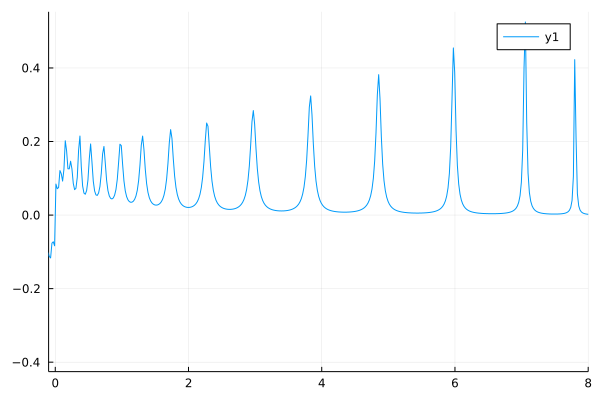

In [53]:
plot(xlim = [-0.1,8])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi))

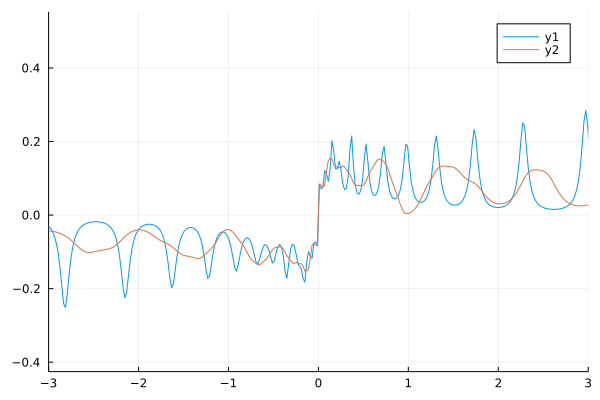

In [54]:
plot(xlim = [-3,3])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)))
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*0.1*real.(sol.reals.freq)))

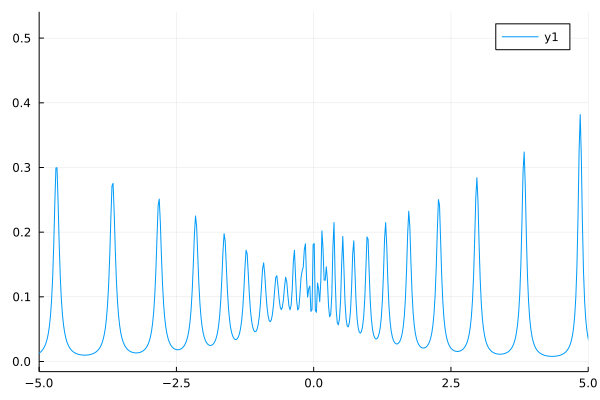

In [55]:
plot(xlim = [-5,5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi))
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)))

In [40]:
ComplexF64.(raw_reals.freq)

1000-element Vector{ComplexF64}:
             -10.0 + 0.01im
 -9.97997997997998 + 0.01im
 -9.95995995995996 + 0.01im
 -9.93993993993994 + 0.01im
 -9.91991991991992 + 0.01im
  -9.8998998998999 + 0.01im
 -9.87987987987988 + 0.01im
 -9.85985985985986 + 0.01im
 -9.83983983983984 + 0.01im
 -9.81981981981982 + 0.01im
  -9.7997997997998 + 0.01im
 -9.77977977977978 + 0.01im
 -9.75975975975976 + 0.01im
                   ⋮
  9.77977977977978 + 0.01im
   9.7997997997998 + 0.01im
  9.81981981981982 + 0.01im
  9.83983983983984 + 0.01im
  9.85985985985986 + 0.01im
  9.87987987987988 + 0.01im
   9.8998998998999 + 0.01im
  9.91991991991992 + 0.01im
  9.93993993993994 + 0.01im
  9.95995995995996 + 0.01im
  9.97997997997998 + 0.01im
              10.0 + 0.01im

In [31]:
function exact_suscep(qx, qy, omega, nsize, beta, hami)
    chi = zeros(ComplexF64, length(omega))
    for iomega in 1:length(omega)
        for ix in 1:nsize, iy in 1:nsize
            kx::Float64 = 2*(ix-1)/nsize
            ky::Float64 = 2*(iy-1)/nsize
            ek  = hami(kx,ky)
            ekq = hami(kx-qx,ky-qy)
            chi[iomega] += -(IRFLEX.fermi_dirac(ekq,beta)-IRFLEX.fermi_dirac(ek,beta))/(omega[iomega]+ekq-ek)
        end
        chi[iomega] = chi[iomega]/(nsize*nsize)
    end
    return chi
end

exact_suscep (generic function with 1 method)

In [45]:
exa_chi = exact_suscep(π,π,ComplexF64.(raw_reals.freq),1024,SparseIR.β(basis),hami)
;

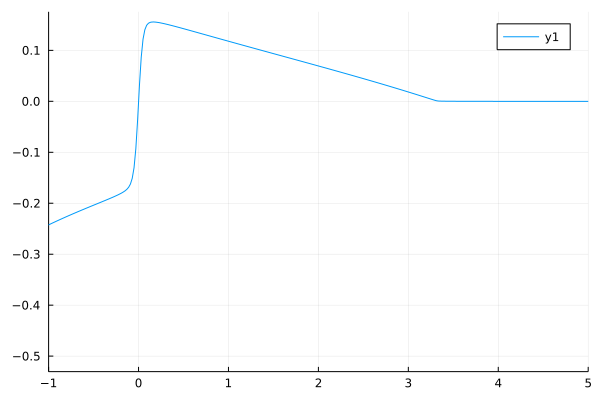

In [46]:
plot(xlim = [-1,5])
plot!(real.(raw_reals.freq), imag.(exa_chi))